In [1]:
%%capture
%run ./core/Track_Processor_Methods.ipynb
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings; warnings.simplefilter('ignore')
import math
from matplotlib.patches import Circle
import itertools
import numpy.linalg
from IPython.display import clear_output, display
from matplotlib import colors
matplotlib.rc('font',family='Arial')
import os
# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual, interactive, Dropdown
# from IPython.display import HTML, display


ppmm = 2.75 #Pixels per millimeter
min_frames = 2 #Minimum frames to be considered for the track
fps = 30 # Video Framerate
flw_thres = 20 #Additional flower radius
data_points = 9 # Number of data collection point
min_duration_on_flower = 5 # Min duration (frames) on a flower to be considered as a visit

In [10]:
track_input_directory = '/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/tracks/processed_tracks_cvpr/'
flower_input_directory = '/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/tracks/raw_flowers/'

summary_data_directory = './data/tracks/summary_data/'
plot_directory = './Graphs/'

csv_tracks = get_video_list(track_input_directory, 'csv')
print('Number of tracks: ', len(csv_tracks))

position_list = [115, 117, 208, 312, 317, 409, 417, 710,810]

Number of tracks:  43


In [11]:
insect_tracks = pd.DataFrame()
track_list =  []
frameN = []
num_bees = 0
for track_ in csv_tracks:
    t  = generateTrackNumber(track_)
    csv_name = str(track_)+'.csv'

    try:
        track_number = int(str(t))
        track1 = pd.read_csv(track_input_directory+str(csv_name))
        # Get the length of the dataframe
        len_track = len(track1)
        if len_track > 5:
                
            frameN = np.append(frameN,len(track1)) 
            track_list = np.append(track_list,int(track_number))

            track1= track1.rename(columns={'Unnamed: 0': 'frame_'+str(t)})
            track1 = track1.set_index('frame_'+str(t))
            track1 = track1.rename(columns={'nframe': 'nframe_'+str(t)})
            # track1 = track1.rename(columns={'absframe': 'absframe_'+str(t)})
            track1 = track1.rename(columns={'x0': 'x0_'+str(t)})
            track1 = track1.rename(columns={'y0': 'y0_'+str(t)})
            track1 = track1.rename(columns={'area': 'area_'+str(t)})
            track1 = track1.rename(columns={'y_adj': 'yadj_'+str(t)})
            track1 = track1.rename(columns={'flower': 'flower_'+str(t)})
            track1 = track1.rename(columns={'visit_num': 'visit_num_'+str(t)})
            # track1 = track1.rename(columns={'sx': 'sx_'+str(t)})
            # track1 = track1.rename(columns={'sy': 'sy_'+str(t)})
            # track1 = track1.rename(columns={'speeds': 'speeds_'+str(t)})
            window_size = 3  # adjust the window size as needed
            track1['sx_'+str(t)] = track1['x0_'+str(t)].rolling(window=window_size, min_periods=1).mean()
            track1['sy_'+str(t)] = track1['y0_'+str(t)].rolling(window=window_size, min_periods=1).mean()    



            insect_tracks = pd.concat([insect_tracks, track1['nframe_'+str(t)], track1['x0_'+str(t)], track1['y0_'+str(t)], track1['area_'+str(t)],
                                    track1['yadj_'+str(t)],track1['flower_'+str(t)],track1['visit_num_'+str(t)],track1['sx_'+str(t)],track1['sy_'+str(t)]],axis=1) 
            
        else:
            pass
    
    except:
        print('Error in track: ', track_)

insect_tracks.head() 

#Group tracks based on the data collection position

tracks_and_dcp = [[] for i in range(data_points)]
for t in track_list: tracks_and_dcp[getDataPoint(str(int(t)))-1].append(t)

    
# Save the combined track file to csv

insect_tracks.to_csv(summary_data_directory + 'all_tracks.csv')
track_list_write = open(summary_data_directory+"track_list.txt", "w")
for track in track_list:
    track_list_write.write(str(int(track)) + "\n")
track_list_write.close()


In [12]:
def generateFlowerPosition0(csv_name):
    fp = csv_name.split('_')[2]
  
    return int(fp)

In [13]:
flower_input_directory0 = '/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/tracks/raw_flowers0/'
flowers_csv = get_video_list('/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/tracks/raw_flowers0/', 'csv')
flower_positions = pd.DataFrame()
# position_list = []
for f in flowers_csv:
    csv_name = str(f)+'.csv'
    fpc = generateFlowerPosition0(f)

    flower1 = pd.read_csv(flower_input_directory0+str(csv_name))

    # get the unique flower_num values
    flower_nums = flower1['flower_num'].unique()

    # Get the max value of index for each flower_num
    max_nframe = flower1.groupby(['flower_num'])['Unnamed: 0'].max()


    # create a new dataframe by extracting all the columns from the original dataframe for the max_nframe index
    flower2 = flower1.loc[flower1.groupby('flower_num')['Unnamed: 0'].idxmax()]

    flower2 = flower2.rename(columns={'flower_num': 'flower_num_'+str(fpc)})
    flower2 = flower2.rename(columns={'x0': 'x0_'+str(fpc)})
    flower2 = flower2.rename(columns={'y0': 'y0_'+str(fpc)})
    # flower2 = flower2.rename(columns={'y_adj': 'y_adj_'+str(fpc)})
    flower2 = flower2.rename(columns={'radius': 'radius_'+str(fpc)})
    # flower2 = flower2.rename(columns={'Total_time': 'Total_time_'+str(fpc)})
    # flower2 = flower2.rename(columns={'Total_visits': 'Total_visits_'+str(fpc)})

    flower_positions = pd.concat([flower_positions, flower2['flower_num_'+str(fpc)], flower2['x0_'+str(fpc)], flower2['y0_'+str(fpc)]
                                     , flower2['radius_'+str(fpc)]],  axis=1)


flower_positions

,flower_num_115,x0_115,y0_115,radius_115,flower_num_117,x0_117,y0_117,radius_117,flower_num_208,x0_208,...,y0_417,radius_417,flower_num_710,x0_710,y0_710,radius_710,flower_num_810,x0_810,y0_810,radius_810
18447,0.0,570.0,404.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18446,1.0,608.0,698.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18451,2.0,711.0,810.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18449,3.0,1128.0,118.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18448,4.0,1205.0,199.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1433.0,824.0,45.0
28276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,254.0,596.0,33.0
28275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,671.0,794.0,34.0
28278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,527.0,776.0,30.0


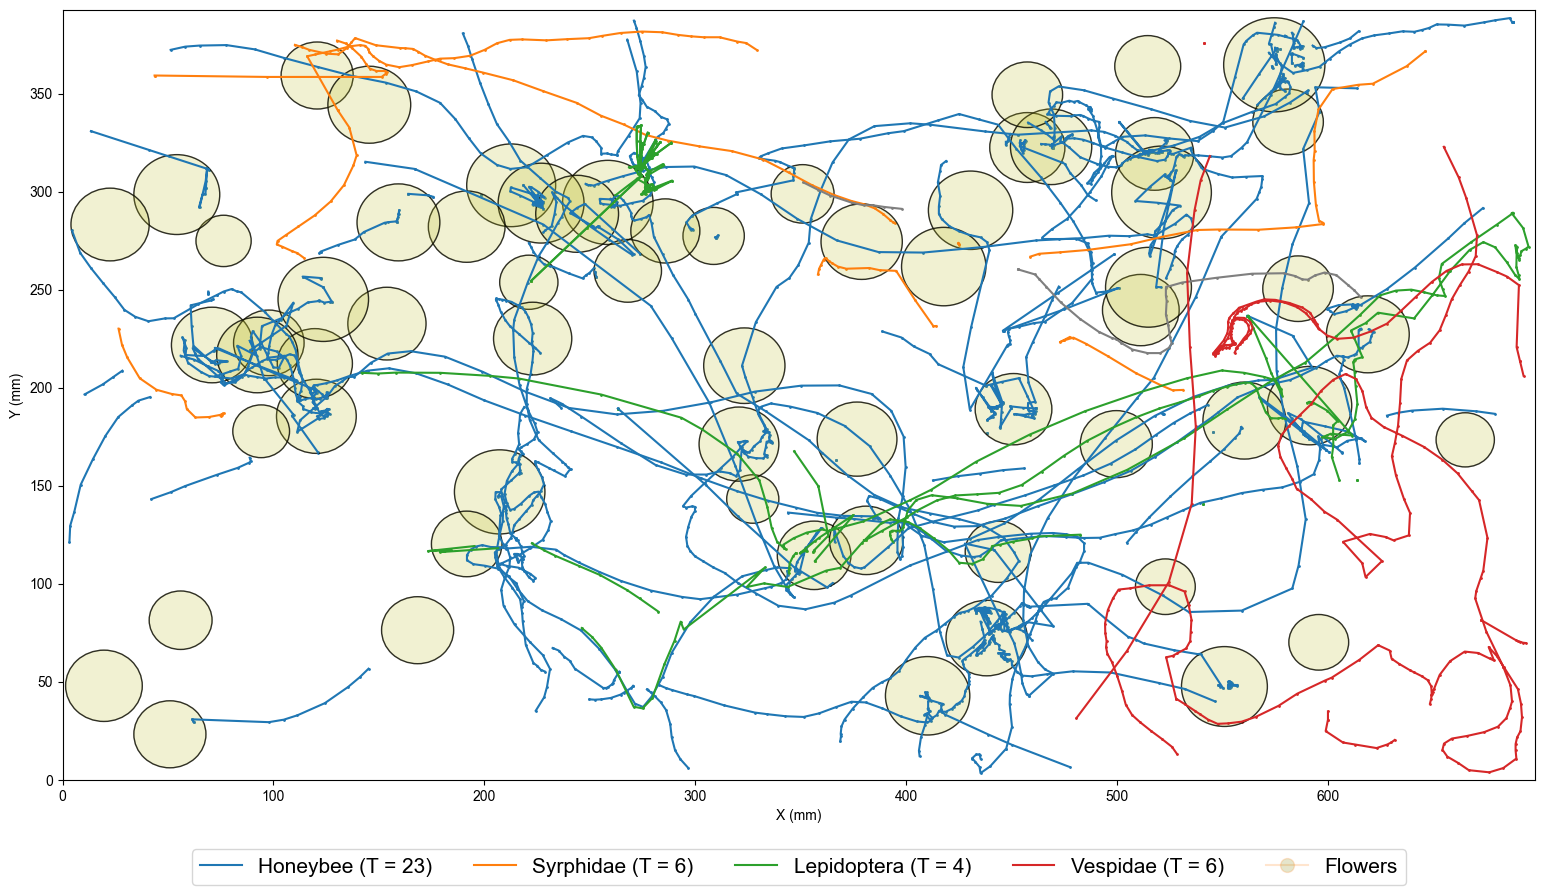

In [55]:
from matplotlib.patches import Circle
from matplotlib.lines import Line2D


#set figure size
# plt.style.use('default')
plt.figure(figsize=(19,10))
n_tracks = 0
for t in track_list:
    # if (getRecordDate(str(t)) in dates_to_plot) and (getSpeciesNumber(t) in species_to_plot):
    plt.plot((insect_tracks['sx_%d'%(int(t))]/ppmm), ((insect_tracks['sy_%d'%(int(t))]/ppmm)), color =getPlotColor(int(t)))
    plt.scatter((insect_tracks['sx_%d'%(int(t))]/ppmm), ((insect_tracks['sy_%d'%(int(t))]/ppmm)), color =getPlotColor(int(t)), s=1)

plt.xlim(0,1920/ppmm)
plt.ylim(0,1080/ppmm)
    #         frame_counts.append(len(insect_tracks['sx_%d'%(int(t))].dropna().tolist()))
    #         n_tracks += 1
    #     else:
    #         pass

flower_count = 0
ax = plt.gca()
for d in position_list:
    for row in flower_positions['x0_'+str(d)].dropna().index.tolist():
        flower_count += 1
        ax.add_patch(Circle((flower_positions['x0_'+str(d)][row]/ppmm, flower_positions['y0_'+str(d)][row]/ppmm), radius = (flower_positions['radius_'+str(d)][row]+flw_thres)/ppmm, color = 'tab:olive', fill=True, alpha = 0.2))
        ax.add_patch(Circle((flower_positions['x0_'+str(d)][row]/ppmm, flower_positions['y0_'+str(d)][row]/ppmm), radius = (flower_positions['radius_'+str(d)][row]+flw_thres)/ppmm, color = 'k', fill=False, alpha = 0.8))

# Add a legend in the bottom center with custom labels for insect species
legend_elements = [Line2D([0], [0], linestyle='-', color=getPlotColor(11513300100), label='Honeybee (T = '+str(len(honeybee_tracks))+")", markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor(11513300101), label='Syrphidae (T = '+str(len(hoverfly_tracks))+")",markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor(11513300102), label='Lepidoptera (T = '+str(len(moth_tracks))+")",markerfacecolor='k', markersize=10),
                   Line2D([0], [0], linestyle='-', color=getPlotColor(11513300103), label='Vespidae (T = '+str(len(wasp_tracks))+")",markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker="o", color=getPlotColor(11513300101), label='Flowers',markerfacecolor='olive', markersize=10, alpha = 0.2)]

# Create the figure
plt.legend(handles=legend_elements, loc=8, ncol=5, frameon=True, fontsize=15, bbox_to_anchor=(0.5, -0.15))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
# plt.savefig(plot_directory+'all_tracks.png', dpi=300, bbox_inches='tight')



plt.show()

In [47]:
insect_tracks

,nframe_11513300100,x0_11513300100,y0_11513300100,area_11513300100,yadj_11513300100,flower_11513300100,visit_num_11513300100,sx_11513300100,sy_11513300100,nframe_11513303900,...,sy_20811271203,nframe_71014275703,x0_71014275703,y0_71014275703,area_71014275703,yadj_71014275703,flower_71014275703,visit_num_71014275703,sx_71014275703,sy_71014275703
0,3521.0,1503.0,110.0,686.0,970.0,NaN,NaN,1503.000000,110.000000,4653.0,...,633.000000,6961.0,1496.0,875.0,758.0,875.0,NaN,NaN,1496.000000,875.000000
1,3522.0,1424.0,145.0,880.0,935.0,NaN,NaN,1463.500000,127.500000,4654.0,...,640.000000,6962.0,1472.0,807.0,1246.0,807.0,NaN,NaN,1484.000000,841.000000
2,3523.0,1361.0,153.0,788.0,927.0,NaN,NaN,1429.333333,136.000000,4655.0,...,645.333333,6963.0,1460.0,714.0,882.0,714.0,NaN,NaN,1476.000000,798.666667
3,3524.0,1315.0,154.0,2382.0,926.0,NaN,NaN,1366.666667,150.666667,4656.0,...,655.333333,6964.0,1467.0,612.0,826.0,612.0,NaN,NaN,1466.333333,711.000000
4,3525.0,1276.0,150.0,2501.0,930.0,NaN,NaN,1317.333333,152.333333,4657.0,...,662.666667,6965.0,1483.0,495.0,1107.0,495.0,NaN,NaN,1470.000000,607.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
honeybee_tracks = []
hoverfly_tracks = []
moth_tracks = []
wasp_tracks = []

for track in track_list:
    last_digit = int(str(int(track))[-1])
    if last_digit == 0:
        honeybee_tracks.append(track)
    elif last_digit == 1:
        hoverfly_tracks.append(track)
    elif last_digit == 2:
        moth_tracks.append(track)
    elif last_digit == 3:
        wasp_tracks.append(track)

print("Honeybee Tracks:", honeybee_tracks)
print("Hoverfly Tracks:", hoverfly_tracks)
print("Moth Tracks:", moth_tracks)
print("Wasp Tracks:", wasp_tracks)


Honeybee Tracks: [11513300100.0, 11513303900.0, 11513305900.0, 11513313000.0, 11513365400.0, 11712303400.0, 11712394400.0, 31212391200.0, 31212402700.0, 31212413000.0, 31212414100.0, 31714304100.0, 31714310600.0, 31714311800.0, 31714331200.0, 40913341500.0, 40913345500.0, 40913351800.0, 71014302100.0, 71014304300.0, 71014315300.0, 71014323000.0, 81013473200.0]
Hoverfly Tracks: [40913315501.0, 41711574301.0, 41711575901.0, 41712110001.0, 41712111901.0, 41712164101.0]
Moth Tracks: [11513335102.0, 11513335402.0, 11513335502.0, 31212370402.0]
Wasp Tracks: [11513375903.0, 20811265803.0, 20811271003.0, 20811271103.0, 20811271203.0, 71014275703.0]


In [52]:
len(honeybee_tracks)

23

In [56]:
position_list

[115, 117, 208, 312, 317, 409, 417, 710, 810]